In [1]:
import torch
from torch import nn

In [2]:
lenet = nn.Sequential(nn.Conv2d(1,6, kernel_size=5, padding=2), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2,stride=2),
                    nn.Conv2d(6,16,kernel_size=5), 
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120), 
                    nn.Sigmoid(),
                    nn.Linear(120,84), nn.Sigmoid(), nn.Linear(84,10)
                    )

In [3]:
X = torch.randn((1,1,28,28))

In [4]:
for layer in lenet:
    X = layer(X)
    
    print(f"Shape of {layer.__class__.__name__} : {X.shape}")

Shape of Conv2d : torch.Size([1, 6, 28, 28])
Shape of Sigmoid : torch.Size([1, 6, 28, 28])
Shape of AvgPool2d : torch.Size([1, 6, 14, 14])
Shape of Conv2d : torch.Size([1, 16, 10, 10])
Shape of Sigmoid : torch.Size([1, 16, 10, 10])
Shape of AvgPool2d : torch.Size([1, 16, 5, 5])
Shape of Flatten : torch.Size([1, 400])
Shape of Linear : torch.Size([1, 120])
Shape of Sigmoid : torch.Size([1, 120])
Shape of Linear : torch.Size([1, 84])
Shape of Sigmoid : torch.Size([1, 84])
Shape of Linear : torch.Size([1, 10])


In [5]:
batch_size = 256


import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [6]:
my_transforms = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(root="../data", download=False, train=True, transform=my_transforms)
test_dataset = datasets.FashionMNIST(root="../data", download=False, train=False, transform=my_transforms)

In [7]:
X,y = train_dataset[0]
X.shape,y

(torch.Size([1, 28, 28]), 9)

In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [9]:
for X, y in train_dataloader:
    print(X, y)
    break

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

Since the full dataset is in the main memory, we need to copy it to the
GPU memory before the model uses GPU to compute with the dataset

In [10]:
def accuracy(y_hat, y):
    return (y_hat.argmax(1)==y).sum()

In [11]:
def evaluate_accuracy_gpu(net, data_iter):
    if isinstance(net, nn.Module):
        net.eval()
        
        device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
    
    acc_arr = 0
    total_number = 0
    
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device).float()
            y = y.to(device).float()
            net = net.to(device)
            y_hat = net(X)
            acc_arr += accuracy(y_hat, y)
            total_number += y.numel()

    return acc_arr/total_number
        
        

In [12]:
#before training
evaluate_accuracy_gpu(lenet, test_dataloader)

tensor(0.1000, device='cuda:0')

In [13]:
import matplotlib.pyplot as plt

In [29]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    
    net.apply(init_weights)
    
    print(f'training on {device}')
    
    net = net.to(device)
    
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    
    train_loss = []
    train_acc = []
    test_acc = []
    
    for epoch in range(num_epochs):
        current_l = 0
        current_numer = 0
        current_acc = 0
        net.train()
        for i, (X, y) in enumerate(train_iter):
            X = X.to(device).float()
            y = y.to(device).long()
            
            y_hat = net(X)
          
            l = loss_criterion(y_hat, y)
            optimizer.zero_grad()
        
            l.backward()
        
            optimizer.step()
            
            current_l += l
            current_numer += X.shape[0]
            current_acc += accuracy(y_hat, y)
            
        print(f'\nFor epoch {epoch} the loss {current_acc/ current_numer}')
        
        with torch.no_grad():
            
            print("\tStatistics:")
            print(f'\tcurrent train loss : {float(current_l/current_numer)}')
            print(f'\tcurrent train acc : {float(current_acc/current_numer)}')
            print(f'\tcurrent test acc : {float(evaluate_accuracy_gpu(net, test_iter))}')
    
            train_loss.append(float(current_l/current_numer))
            train_acc.append(float(current_acc/current_numer))
            test_acc.append(float(evaluate_accuracy_gpu(net, test_iter)))
    
    with torch.no_grad():
        print(len(train_loss), len(train_acc), len(test_acc))
        print(type(train_loss), type(train_acc), type(test_acc))
        plt.plot(range(num_epochs), train_loss)
        plt.plot(range(num_epochs), train_acc)
        plt.plot(range(num_epochs), test_acc)
        plt.grid(True)
        plt.show()
        

training on cuda

For epoch 0 the loss 0.10226666927337646
	Statistics:
	current train loss : 0.009085250087082386
	current train acc : 0.10226666927337646
	current test acc : 0.09999999403953552

For epoch 1 the loss 0.3962666690349579
	Statistics:
	current train loss : 0.006170948967337608
	current train acc : 0.3962666690349579
	current test acc : 0.5760999917984009

For epoch 2 the loss 0.6559000015258789
	Statistics:
	current train loss : 0.0034632282331585884
	current train acc : 0.6559000015258789
	current test acc : 0.6793999671936035

For epoch 3 the loss 0.7172666788101196
	Statistics:
	current train loss : 0.0028336301911622286
	current train acc : 0.7172666788101196
	current test acc : 0.6642000079154968

For epoch 4 the loss 0.7457500100135803
	Statistics:
	current train loss : 0.0025477877352386713
	current train acc : 0.7457500100135803
	current test acc : 0.7080000042915344

For epoch 5 the loss 0.772766649723053
	Statistics:
	current train loss : 0.002303646644577384
	

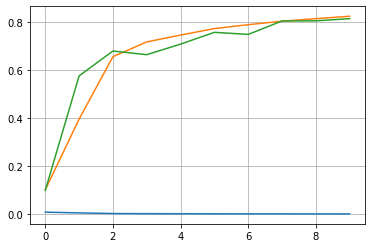

In [30]:
lr, num_epochs = 0.005, 10

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

train_ch6(lenet, train_iter=train_dataloader, test_iter=test_dataloader, num_epochs=num_epochs, lr=0.9, device=device)

## Exercises

1. Replace the average pooling with maximum pooling. What happens?
1. Try to construct a more complex network based on LeNet to improve its accuracy.
    1. Adjust the convolution window size.
    1. Adjust the number of output channels.
    1. Adjust the activation function (e.g., ReLU).
    1. Adjust the number of convolution layers.
    1. Adjust the number of fully connected layers.
    1. Adjust the learning rates and other training details (e.g., initialization and number of epochs.)
1. Try out the improved network on the original MNIST dataset.
1. Display the activations of the first and second layer of LeNet for different inputs (e.g., sweaters and coats).
